Описание эксперимента:

Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом

Описание колонок:

value – значения метрики,

experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

Задача:

1. Сравнить результат между тестом и контролем по двум кейсам:

Применить бутстрап (с np.mean) и критерий mann-whitney, а потом сравнить p-value.

Применить бутстрап (с np.median) и критерий mann-whitney, а потом сравнить p-value.
2. Напиcать выводы, которые можно сделать на основе анализа примененных критериев

In [38]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [40]:
df

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control
...,...,...,...
995,996,1000,Treatment
996,997,1200,Treatment
997,998,1500,Treatment
998,999,2000,Treatment


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         1000 non-null   int64 
 1   value              1000 non-null   object
 2   experimentVariant  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [42]:
df['value']=df.value.str.replace(',','.').astype(float)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1000 non-null   int64  
 1   value              1000 non-null   float64
 2   experimentVariant  1000 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 23.6+ KB


Посмотрю на данные и построю гистограмму распределения в двух группах

In [44]:
x=df[df['experimentVariant']=='Treatment']['value']
y=df[df['experimentVariant']=='Control']['value']
x.name='Value-treatment group'
y.name='Value -control group'

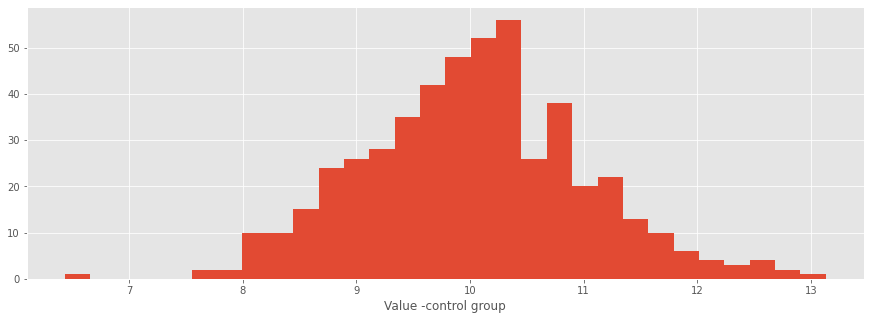

In [45]:
plt.figure(figsize=(15,5))
plt.hist(y, bins=30) 
plt.xlabel(y.name)
plt.show()


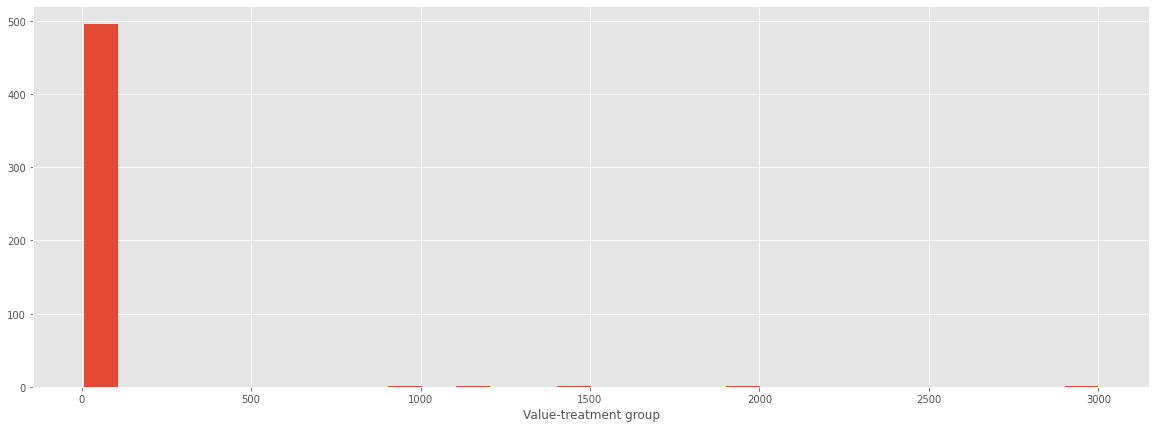

In [46]:
plt.figure(figsize=(20,7))
plt.hist(x, bins=30)
plt.xlabel(x.name)
plt.show()

Группа Treatment имеет существенные выбросы, идея сравнивать группы по средним арифметическим не очень удачная. Возможно нужно удалить эти выбросы


Бутстрап по среднему значению:

In [47]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap_mean(
    control_value, # числовые значения первой выборки
    treatment_value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(control_value), len(treatment_value)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = control_value.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = treatment_value.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
# Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data-MEAN")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [48]:
treatment=df[df.experimentVariant=='Treatment']['value']
control=df[df.experimentVariant=='Control']['value']

In [49]:
np.random.seed(5)

n = 10000
lift = 1.01
x=control
y=treatment

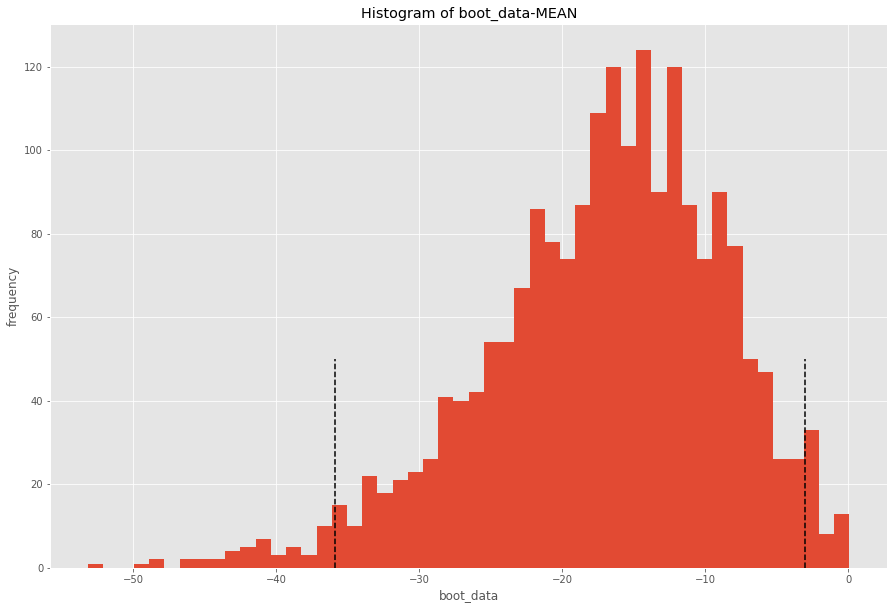

In [50]:
plt.figure(figsize=(15,10))
booted_data_mean = get_bootstrap_mean(x, y, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [51]:
booted_data_mean["p_value"]

0.04056953210214689

Тест Манна-Уитни:

In [52]:
res=stats.mannwhitneyu (x,y)
print('p-value:', res[1])

p-value: 0.8592148582485579


p-value получилось достаточно большим, поэтому у нас нет оснований отвергнуть гипотезу. Вывод: значения метрики различаются незначимо-разница средних в выборках случайна

Результаты бутстарпа по среднему и Манн-Уитни дают разные результаты

Посчитаю p-value бутстрапом на основе медианы

In [53]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
# Медиана

def get_bootstrap_median(
    control_value, # числовые значения первой выборки
    treatment_value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(control_value), len(treatment_value)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = control_value.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = treatment_value.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
# Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data-MEDIAN")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [54]:
np.random.seed(5)

n = 10000
lift = 1.01
x=control
y=treatment

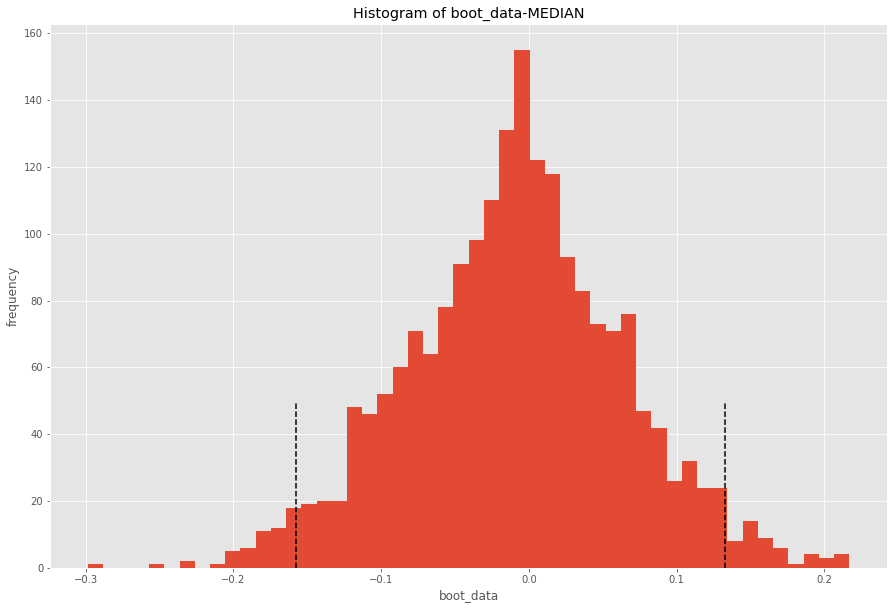

In [55]:
plt.figure(figsize=(15,10))
booted_data_median = get_bootstrap_median(x, y, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [72]:
booted_data_median["p_value"]

0.8990168644998555

В данном случае Манн-Уитни дает схожие с бутстрапом результаты

Итого, в результате проведения теста Манн-Уитни и бутстарапа по среднему и медиане, мы получили различные результаты тестов.В случае Манн_Уитни и бутстарпа по медиане у нас нет оснований для отклонения нулевой гипотезы. В случае с бутстапом по среднему- есть основание ее отклонить.

Попробую тесты на выборках без выбросов

In [ ]:
df2=df.query('value > 20') # проверяю

In [57]:
df2

,Unnamed: 0,value,experimentVariant
995,996,1000.0,Treatment
996,997,1200.0,Treatment
997,998,1500.0,Treatment
998,999,2000.0,Treatment
999,1000,3000.0,Treatment


In [58]:
df3=df.query('value < 7')# проверяю

In [59]:
df3

,Unnamed: 0,value,experimentVariant
164,165,6.436541,Control
664,665,6.436541,Treatment


In [60]:
df1=df.query('value < 50 and value > 7')

In [61]:
df1

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control
...,...,...,...
990,991,10.916229,Treatment
991,992,11.160869,Treatment
992,993,8.202518,Treatment
993,994,9.782199,Treatment


In [62]:
x=df1[df1['experimentVariant']=='Treatment']['value']
y=df1[df1['experimentVariant']=='Control']['value']
x.name='Value-treatment group. No outliers'
y.name='Value -control group. No outliers'

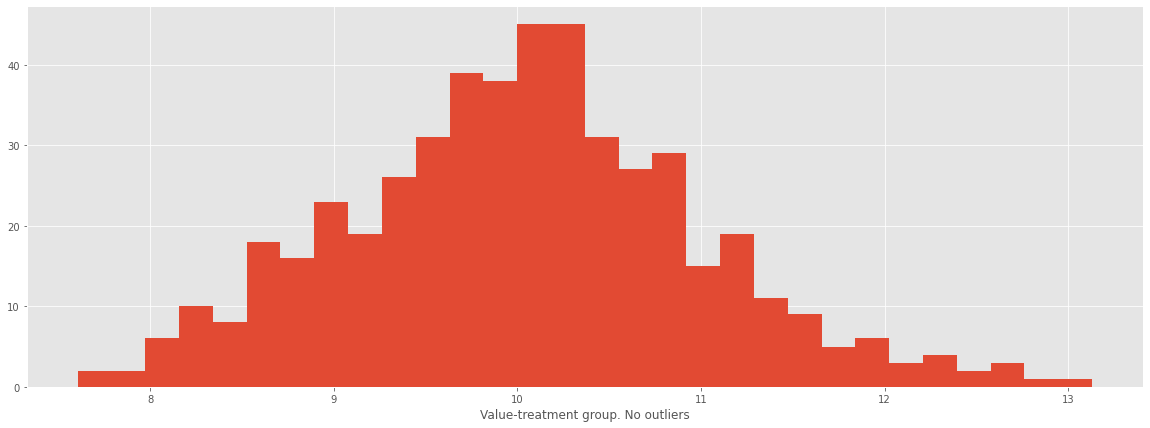

In [63]:
plt.figure(figsize=(20,7))
plt.hist(x, bins=30)
plt.xlabel(x.name)
plt.show()

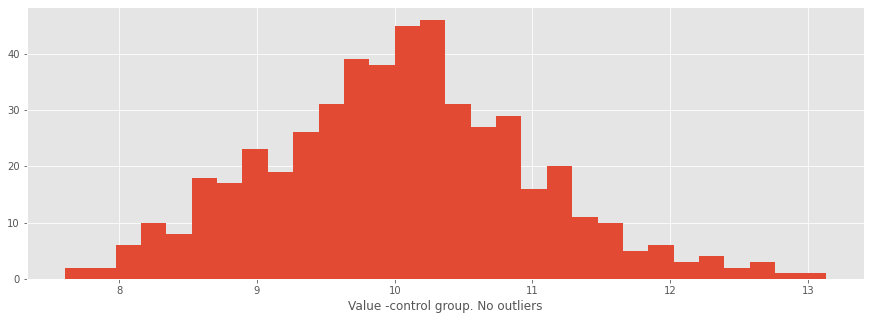

In [64]:
plt.figure(figsize=(15,5))
plt.hist(y, bins=30) 
plt.xlabel(y.name)
plt.show()


теперь распределения больше похожи на нормальное

In [65]:
treatment_1=df1[df1.experimentVariant=='Treatment']['value']
control_1=df1[df1.experimentVariant=='Control']['value']

In [66]:
np.random.seed(5)

n = 10000
lift = 1.01
x_1=control_1
y_1=treatment_1

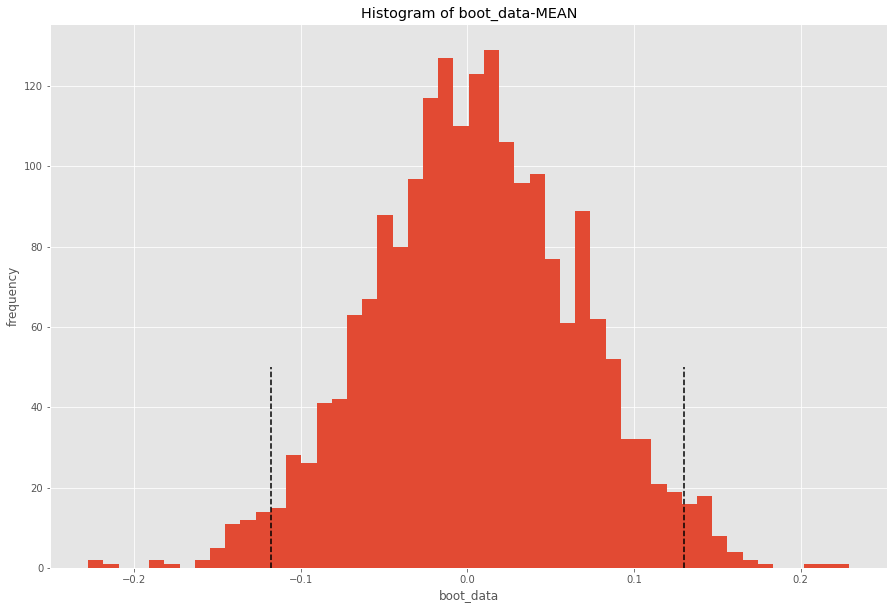

In [67]:
plt.figure(figsize=(15,10))
booted_data_mean_1 = get_bootstrap_mean(x_1, y_1, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

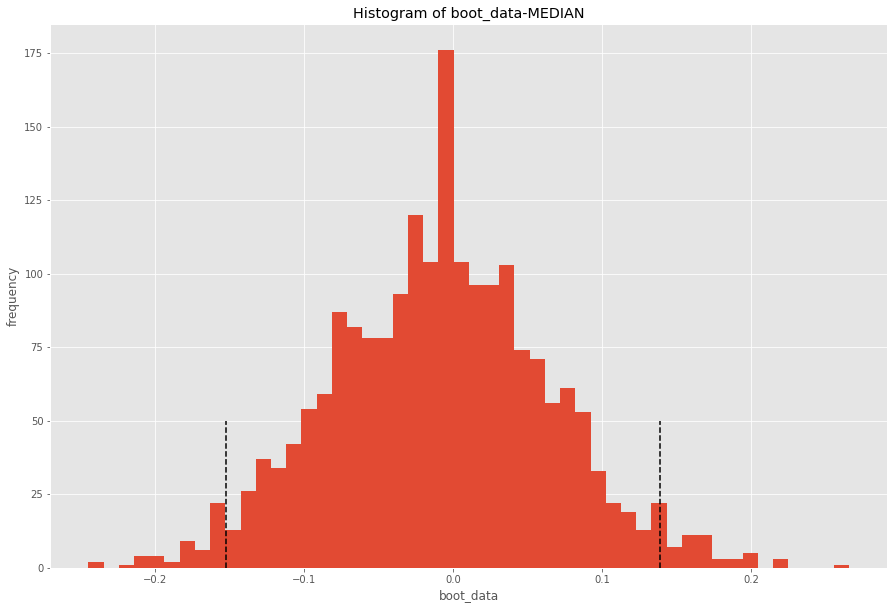

In [68]:
plt.figure(figsize=(15,10))
booted_data_median_1 = get_bootstrap_median(x, y, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [69]:
booted_data_mean_1["p_value"]

0.9340728736614488

In [70]:
booted_data_median_1["p_value"]

0.9066195180069978

In [71]:
res=stats.mannwhitneyu (x_1,y_1)
print('p-value:', res[1])

p-value: 0.9230455646040819


Вывод: отбросив вылетающие значения все три теста дают схожие результаты


## Итого
* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
* Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
* U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы